In [1]:
from transformers import DistilBertTokenizer, DistilBertModel
from utils_data import *
from trainer import *
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch

C:\Users\Lei\miniconda3\envs\Asset2Vec\lib\site-packages\neptune\common\warnings.py:62: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  warnings.warn(
C:\Users\Lei\miniconda3\envs\Asset2Vec\lib\site-packages\neptune\common\warnings.py:62: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  warnings.warn(


In [2]:
embd = EmbeddingTrainer.load_from_checkpoint('checkpoints/04e2bf46-ee06-4065-9c6a-961f8856c30e.ckpt').embedder.cuda()

C:\Users\Lei\miniconda3\envs\Asset2Vec\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'embedder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['embedder'])`.
  rank_zero_warn(


In [3]:
metadata = pd.read_csv('data/Top 2000/t2k_metadata.csv', index_col=0)

In [4]:
TOKENIZER = RobertaTokenizer.from_pretrained('tokenizer/')
metadata.loc['Description'] = metadata.loc['Description'].apply(
            TOKENIZER, max_length=512, return_tensors='pt', padding='max_length', return_attention_mask=True, is_split_into_words=False
        )

In [6]:
total_stocks = len(metadata.columns)
embeddings = pd.DataFrame(data=np.zeros((30, total_stocks)), columns=metadata.columns)

for stock in tqdm(metadata.columns, total=total_stocks):
    desc = metadata.loc['Description', stock]
    embeddings[stock] = embd(desc['input_ids'].cuda(), desc['attention_mask'].cuda()).detach().cpu().numpy()[0]

100%|██████████| 1961/1961 [00:14<00:00, 133.76it/s]


In [7]:
from sklearn.decomposition import PCA
m = PCA(n_components=2)
reduced = m.fit_transform(embeddings.T).T
reduced = pd.DataFrame(data=reduced, columns=metadata.columns)

In [8]:
reduced.head()

,A,AA,AAL,AAON,AAP,AAPL,AAT,AAWW,AB,ABBV,...,ZETA,ZI,ZION,ZIP,ZM,ZNTL,ZS,ZTS,ZUO,ZWS
0,0.006937,0.004137,-0.010462,-0.070676,0.047711,-0.083427,-0.001876,0.091338,-0.032779,0.030692,...,0.014397,-0.044096,0.024178,0.153684,-0.022496,0.025475,-0.047721,0.058804,0.044960,0.004088
1,-0.030993,0.010146,-0.035322,-0.021228,-0.028413,0.016461,0.018617,-0.010285,0.027617,-0.020807,...,-0.009348,-0.019114,-0.029409,-0.027452,0.023485,0.075801,-0.001265,-0.032218,-0.004661,-0.020607


<Axes: xlabel='0', ylabel='1'>

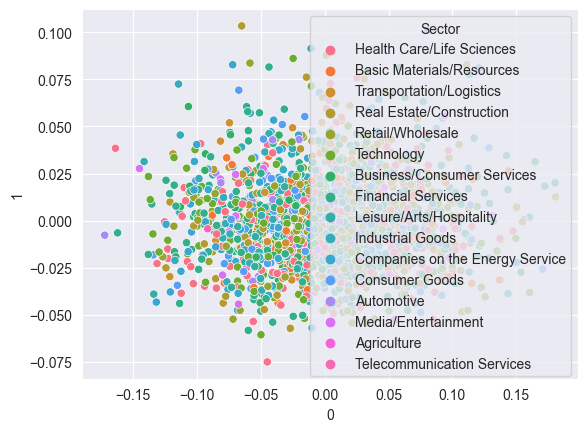

In [9]:
import seaborn as sns
sns.scatterplot(x=reduced.iloc[0], y=reduced.iloc[1], hue=metadata.loc['Sector'])

In [13]:
embeddings.to_csv('data/Top 2000/t2k_embeddings.csv')

In [20]:
dist = [sum(np.square(embeddings[stock] - embeddings['AMZN'])) for stock in embeddings.columns]
idx = np.argsort(dist)
embeddings.columns[idx][:10]

Index(['AMZN', 'EQIX', 'MRNA', 'ARIS', 'PAYX', 'CGNX', 'CPRX', 'NTRA', 'O',
       'AMED'],
      dtype='object')